In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
from griddedoutput_plotting import *
from loaddatastructs import *

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import matplotlib.patches as mpatches

In [2]:
data_path = os.path.join(os.getcwd(), '..', 'data')
GriddedOutput.archive_path = f'{data_path}/processed_data'

GriddedOutput.gridsize = 100

# update initial conditions to correct for issue with mass fractions 
scenarios = ['no-heterogeneity', 'high-heterogeneity']
for scenario in scenarios:
    GriddedOutput.addScenario(scenario_name=scenario,
                            aero_data_filename=f'{scenario}_subset_t36.nc', 
                            load_aerodist_data=False,
                            load_wrf_data=False)

..using no-heterogeneity as basecase for simulation attributes
....n_times: 1
....n_levels: 100
....domain_x_cells: 100
....domain_y_cells: 100
....historydelta_m: None


Loading file
Loading file
Loading file
Loading file


/var/folders/3p/g6j_y4hj63v0_klskdgcx7jm0000gr/T/ipykernel_58807/877268357.py:50: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin
/var/folders/3p/g6j_y4hj63v0_klskdgcx7jm0000gr/T/ipykernel_58807/877268357.py:50: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin


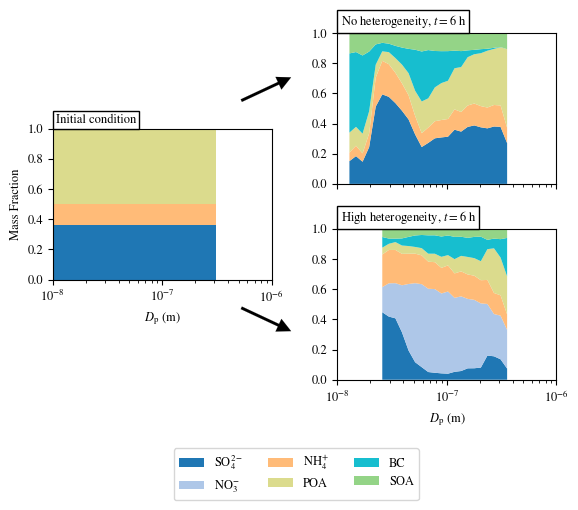

In [ ]:
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing
z_idx = 40 # 0 indexing

def plotThreePanelMassFrac(xstart, xend, ystart, yend, z_idx, **kwargs):

    fig, axs  = plt.subplots(2,2, figsize=(6.5,4.5))
    plt.subplots_adjust(hspace=.3, wspace=.3)
    # turn off the axis for the bottom left subplot
    axs[1,0].axis('off')
    axs[1, 0].remove()

    # move the first subplot to the center of the left column
    bbox = axs[0,0].get_position()
    axs[0,0].set_position([bbox.x0,0.5*(1 - bbox.height), bbox.width, bbox.height])

    for j, ax in enumerate(axs.flatten()):
        if j == 0:
            s = 'no-heterogeneity'
            t = 1
        else:
            t = 36
            if j == 1:
                s = 'no-heterogeneity'
            else:
                s = 'high-heterogeneity'

        GriddedOutput.loadData(s, xstart, xend, ystart, yend, z_idx, t)
     
        binned_species_mass_arr =  getBinnedSpeciesMassOptimized(GriddedOutput.gridded_data[s]['aero_diams'],
                                                                GriddedOutput.gridded_data[s]['aero_masses'], 
                                                                GriddedOutput.gridded_data[s]['aero_numconc'], 
                                                                n_grid_cells=GriddedOutput.gridded_data[s]['n_total_cells'])

        if binned_species_mass_arr.shape[1] == GriddedOutput.n_bins:
                    binned_species_mass_arr = binned_species_mass_arr[:, :-1]

        total_mass_per_bin = (binned_species_mass_arr[:, :]#/bin_logwidth # moved division by logwidth to calculation of mass distrib
                            ).sum(axis=0)
        frac_total = np.zeros((GriddedOutput.n_bins-1,))

        # Plot the total speciated mass distribution
        aero_species = [var for var in GriddedOutput.aero_vars if 'pmc_' in var]
        negibable_species_idx = []
        negigable_species_names = []
        # create a new variable for all SOA species
        soa_species_frac = np.zeros((GriddedOutput.n_bins-1,))
        for i, species in enumerate(aero_species):
            species_mass_dist = binned_species_mass_arr[i, :]#/bin_logwidth # moved division by logwidth to calculation of mass distrib
            species_frac = species_mass_dist/total_mass_per_bin

            

            #if j == 2:
            #    print(species, species_frac)
            frac_total += species_frac
            if i == 0:
                y_lower = 0
                y_lower = np.array((GriddedOutput.n_bins-1)*[y_lower])
            else:
                y_lower = frac_total - species_frac

            variable_fmt = GriddedOutput.aerosol_fmt_map[species]
            variable_fmt = variable_fmt.replace('Aerosol ', '')
            if variable_fmt == 'OC': # rename OC to POA
                variable_fmt = 'POA'
            #if ('ARO' in species) or ('ALK' in species) or ('OLE' in species) or ('API' in species) or ('LIM' in species):
            #    variable_fmt = variable_fmt.replace('_', '')
            if variable_fmt in ['CL', 'NA', 'CA']:
                variable_fmt = variable_fmt.title()

            #print(species, np.nanmean(species_frac))
            if j == 2 and np.nanmean(species_frac) < 0.01:
                negibable_species_idx.append(i)
                negigable_species_names.append(variable_fmt)
                #print(variable_fmt, np.nanmean(species_frac))

            if (np.nanmean(species_frac) > 0.01) and any(prefix in species for prefix in ['ARO', 'ALK', 'OLE', 'API']):
                soa_species_frac += species_frac
                frac_total -= species_frac

            if np.nanmean(species_frac) < 0.01:
                frac_total -= species_frac

            ax.fill_between(x=GriddedOutput.bin_geocenter, y1=y_lower, y2=frac_total, label=variable_fmt)

        # plot SOA fraction
        frac_total += soa_species_frac
        y_lower = frac_total - soa_species_frac
        ax.fill_between(x=GriddedOutput.bin_geocenter, y1=y_lower, y2=frac_total, label='SOA', facecolor='#94D487')

        # set xlim, ylim, axis scaling
        ax.set_xlim(GriddedOutput.bin_edges[0], GriddedOutput.bin_edges[-1])
        ax.set_ylim(0, 1)
        ax.set_xscale('log')
        if kwargs.get('xlims'):
            ax.set_xlim(kwargs.get('xlims'))

        # add legend
        fontsize= kwargs.get('global_fontsize', 11)
        if j == 2:
            handles, labels = ax.get_legend_handles_labels()



            # Filter handles and labels together based on the negligible species names
            filtered_handles_labels = [
                (handle, label) for handle, label in zip(handles, labels)
                if label not in (negigable_species_names + ['ARO$_1$', 'ALK$_1$', 'OLE$_1$'])
            ]
            
            # Unzip filtered handles and labels
            filtered_handles, filtered_labels = zip(*filtered_handles_labels) if filtered_handles_labels else ([], [])
            fig.legend(handles=filtered_handles, labels=filtered_labels, fontsize=fontsize, ncol=3, loc='center', bbox_to_anchor=(.5,-.1))

        # Set x-axis ticks and labels
        if j == 1:
            #pass
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(r'$D_{\mathrm{p}}$ (m)', fontsize=fontsize)

        # Set y-axis ticks and labels
        if j in [1,3]:
            pass
            #ax.set_yticklabels([])
        else:
            # Set y-axis ticks and label
            ax.set_ylabel('Mass Fraction', fontsize=fontsize)  

        ax.tick_params(axis='both', which='major', labelsize=fontsize)
                
        if j == 0:
            text = 'Initial condition'
        if j == 1:
            text = 'No heterogeneity, $t=6$ h'
        if j == 2:
            text = 'High heterogeneity, $t=6$ h'

        txt = AnchoredText(f'{text}',
                        loc='lower left', prop=dict(size=fontsize), frameon=True,
                        bbox_to_anchor=(0., 1.), borderpad=0, pad=0.25,
                        bbox_transform=ax.transAxes
                        )
        ax.add_artist(txt)

        if j == 0:
            x_tail = .85
            y_tail = 1.18
            x_head = 1.1
            y_head = 1.35
            dx = x_head - x_tail
            dy = y_head - y_tail

            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 #mutation_scale=100, 
                                 lw=.1, facecolor='k', 
                                 arrowstyle='Simple,head_width=10,head_length=10,tail_width=2',  # Arrow thickness
                                 transform=ax.transAxes)
            arrow.set_clip_on(False)
            ax.add_patch(arrow)

            x_tail = .85
            y_tail = -0.18
            x_head = 1.1
            y_head = -.35
            dx = x_head - x_tail
            dy = y_head - y_tail

            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 #mutation_scale=100, 
                                 lw=.1, facecolor='k', 
                                 arrowstyle='Simple,head_width=10,head_length=10,tail_width=2',  # Arrow thickness
                                 transform=ax.transAxes)
            arrow.set_clip_on(False)
            ax.add_patch(arrow)
            

    if kwargs.get("savefig"):
        plt.savefig(f'speciated-mass-frac-three-panel-z{z_idx}.pdf', format='pdf', bbox_inches='tight')


plotThreePanelMassFrac(xstart, xend, ystart, yend, z_idx, xlims=(1e-8, 1e-6), 
                      global_fontsize=9, savefig=True)

In [ ]:
def computeAeroParticleCriticalDiameter(Dp, kappa):
    CRIT_DIAM_MAX_ITER = 100    
    sigma_sa = 0.072 # J m^-2 (Petters and Kreidenweis)
    T = 298.15 # K
    M_w = 18.01 # g mol^-1
    R = 8.3145 # J mol^-1 K^-1
    rho_w = 1e6 # g m^-3

    A = (4*sigma_sa*M_w)/(R*T*rho_w)
    dry_diam = Dp 

    if kappa < 1e-30:
        aero_particle_crit_diam = dry_diam
        return aero_particle_crit_diam
    
    c4 = -3*dry_diam**3*kappa / A
    c3 = -1*dry_diam**3*(2-kappa)
    c0 = dry_diam**6*(1-kappa)
    
    # Newtons method for f(d) = d^6 + c4 d^4 + c3 d^3 + c0
    d = max(np.sqrt((-4/3)*c4), (-1*c3**(1/3)))
    for i in range(CRIT_DIAM_MAX_ITER):
        f = d**6 + c4*d**4 + c3*d**3 + c0
        df = 6*d**5 + 4*c4*d**3 + 3*c3*d**2
        dd = f / df
        d = d - dd
        if np.abs(dd/d) < 1e-14:
            break

    return d

def computeAeroParticleCriticalRelHumid(Dp, kappa):
    sigma_sa = 0.072 # J m^-2 (Petters and Kreidenweis)
    T = 293.5 # K  (approximate temperature at inversion layer at t = 6 hr)
    M_w = 18.01 # g mol^-1
    R = 8.3145 # J mol^-1 K^-1
    rho_w = 1e6 # g m^-3

    A = (4*sigma_sa*M_w)/(R*T*rho_w)
    dry_diam = Dp 
    crit_diam = computeAeroParticleCriticalDiameter(Dp, kappa)

    if kappa < 1e-30:
        aero_particle_crit_rel_humid = np.exp(A/crit_diam)
        return aero_particle_crit_rel_humid
    else:
        aero_particle_crit_rel_humid = (crit_diam**3 - dry_diam**3) / (crit_diam**3 - dry_diam**3 * (1 - kappa))*np.exp(A/crit_diam)
        return aero_particle_crit_rel_humid

def plotThreePanel2DKappaDist(xstart, xend, ystart, yend, z_idx, **kwargs):

    fig, axs  = plt.subplots(2,2, figsize=(6.5,4.5))
    plt.subplots_adjust(hspace=.3, wspace=.3)
    # turn off the axis for the bottom left subplot
    #axs[1,0].axis('off')
    #axs[1, 0].remove()

    fig.delaxes(axs[1, 0])

    # move the first subplot to the center of the left column
    bbox = axs[0,0].get_position()
    axs[0,0].set_position([bbox.x0,0.5*(1 - bbox.height), bbox.width, bbox.height])

    for j, ax in enumerate(axs.flatten()):
        if j == 0:
            s = 'no-heterogeneity'
            t = 1
        else:
            t = 36
            if j == 1:
                s = 'no-heterogeneity'
            else:
                s = 'high-heterogeneity'
                
        GriddedOutput.loadData(s, xstart, xend, ystart, yend, z_idx, t)

        # 1-d arrays with per-particle attributes
        kappa = GriddedOutput.gridded_data[s]['aero_kappa']
        diams = GriddedOutput.gridded_data[s]['aero_diams']
        numconc = GriddedOutput.gridded_data[s]['aero_numconc']
        n_cells = GriddedOutput.gridded_data[s]['n_total_cells']

        diam_bins = np.logspace(-8, -6, 50)
        #diam_bins = GriddedOutput.bin_edges
        kappa_bins = np.linspace(0, 1, 51)
        diam_logwidth = (np.log10(diam_bins[1:]) - np.log10(diam_bins[0:-1]))[0]
        kappa_width = (kappa_bins[1:] - kappa_bins[0:-1])[0]
        hist, xedges, yedges, cs = ax.hist2d(diams, kappa, bins=[diam_bins, kappa_bins], weights=numconc/(diam_logwidth*n_cells), 
                                            density=False, cmin=1,edgecolor='face', linewidth=.1,
                                            norm = mplcolors.LogNorm(1e7, 1e10), zorder=2)
        ax.set_xscale('log')

        #fontsize=9
        fontsize= kwargs.get('global_fontsize', 11)

        if kwargs.get('xlims'):
            ax.set_xlim(kwargs.get('xlims'))

        # Set x-axis ticks and labels
        if j == 1:
            #pass
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(r'$D_{\mathrm{p}}$ (m)', fontsize=fontsize)

        # Set y-axis ticks and labels
        if j in [1,3]:
            pass
            #ax.set_yticklabels([])
        else:
            # Set y-axis ticks and label
            ax.set_ylabel('$\kappa$', fontsize=fontsize)  

        ax.tick_params(axis='both', which='major', labelsize=fontsize)
                
        if j == 0:
            text = 'Initial condition'
        if j == 1:
            text = 'No heterogeneity, $t=6$ h'
        if j == 2:
            text = 'High heterogeneity, $t=6$ h'

        txt = AnchoredText(f'{text}',
                        loc='lower left', prop=dict(size=fontsize), frameon=True,
                        bbox_to_anchor=(0., 1.), borderpad=0, pad=0.25,
                        bbox_transform=ax.transAxes
                        )
        ax.add_artist(txt)

        ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.4,6), c='#414141', alpha=.5, zorder=0)
        ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.4,6), c='#414141', zorder=0)
        ax.grid(which = "minor", linewidth = .8, axis='y', ls="dotted", dashes=(.4,4), c='white', zorder=0)
        ax.grid(which = "minor", linewidth = .8, axis='x', ls="dotted", dashes=(.4,4), c='#414141', zorder=0)
        
        # add arrows pointing from initial condition plot to scenario plots at t=6 h
        if j == 0:
            x_tail = .85
            y_tail = 1.18
            x_head = 1.1
            y_head = 1.35
            dx = x_head - x_tail
            dy = y_head - y_tail

            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                    #mutation_scale=100, 
                                    lw=.1, facecolor='k', 
                                    arrowstyle='Simple,head_width=10,head_length=10,tail_width=2',  # Arrow thickness
                                    transform=ax.transAxes)
            arrow.set_clip_on(False)
            ax.add_patch(arrow)

            x_tail = .85
            y_tail = -0.18
            x_head = 1.1
            y_head = -.35
            dx = x_head - x_tail
            dy = y_head - y_tail

            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                    #mutation_scale=100, 
                                    lw=.1, facecolor='k', 
                                    arrowstyle='Simple,head_width=10,head_length=10,tail_width=2',  # Arrow thickness
                                    transform=ax.transAxes)
            arrow.set_clip_on(False)
            ax.add_patch(arrow)

        # Add supersaturation contours
        diams = np.logspace(-8, -6, 300)
        kappas = np.linspace(0, 1, 300)

        Sc_map = np.zeros((len(diams), len(kappas)))
        for i, diam in enumerate(diams):
            for j, kappa in enumerate(kappas):
                Sc_map[i, j] = computeAeroParticleCriticalRelHumid(diam, kappa)

        contour_levels = [1.001, 1.003, 1.006, 1.01]
        contours = ax.contour(diams, kappas, Sc_map.T, vmin=1, vmax=1.01, linewidths=1.5, 
                            levels=contour_levels, colors=['k'], # #D42F0C
                            zorder=3)

        fmt = {}
        strs = [f'{100*(level-1):3.1f}%' for level in contour_levels]
        for l, s in zip(contours.levels, strs):
            fmt[l] = s
        ax.clabel(contours, inline=True, fontsize=fontsize, fmt=fmt, manual=[(2.5e-8, 0.76), (3.5e-8, 0.78), (7e-8, 0.82), (1.5e-7, 0.86)])

        
    cbar = fig.colorbar(cs, ax=axs, orientation='vertical', #aspect=20, 
                            fraction=0.04, pad=0.05)
    cbar_title = 'Number conc. (m$^{-3}$)'
    cbar.set_label(label=cbar_title, fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)

    if kwargs.get("savefig"):
        plt.savefig(f'2d-kappa-dist-three-panel-z{z_idx}.pdf', format='pdf', bbox_inches='tight')

Loading file


/var/folders/3p/g6j_y4hj63v0_klskdgcx7jm0000gr/T/ipykernel_58807/3398515865.py:21: RuntimeWarning: invalid value encountered in scalar power
  d = max(np.sqrt((-4/3)*c4), (-1*c3**(1/3)))


Loading file


/var/folders/3p/g6j_y4hj63v0_klskdgcx7jm0000gr/T/ipykernel_58807/3398515865.py:21: RuntimeWarning: invalid value encountered in scalar power
  d = max(np.sqrt((-4/3)*c4), (-1*c3**(1/3)))


Loading file
Loading file


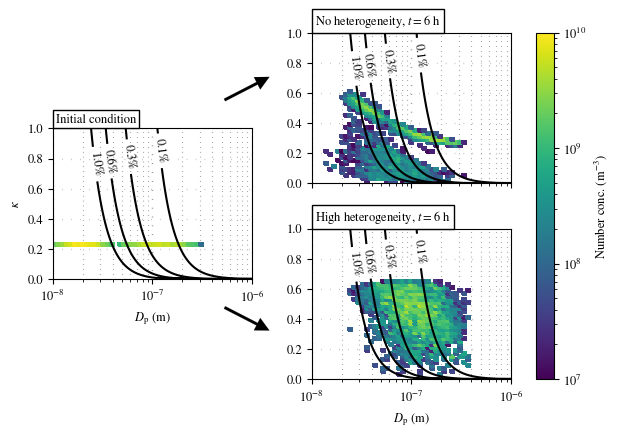

In [5]:
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing
z_idx = 40 # 0 indexing

plotThreePanel2DKappaDist(xstart, xend, ystart, yend, z_idx, xlims=(1e-8, 1e-6), 
                      global_fontsize=9, savefig=True)